<center><h3>Suplementary material for the paper</h3></center>
<center><h2>Uncertainty Quantification in Deep Residual Networks with Stochastic Depth</h2></center>
<center><h3>ICCV 2019</h3></center>
<center><h3>Evaluation on the CIFAR-10 dataset</h3></center>

## 0. Initialize

In [1]:
import sys
import tqdm
import numpy as np

from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from deterministic import resnet_cifar as resnet_small_deterministic
from spatial_dropout import resnet_cifar as resnet_small_dropout
from batch_normalization import resnet_cifar as resnet_small_batch_normalization
from stochastic_depth import resnet_cifar as resnet_small_stochastic
import utils

# Reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

batch_size = 100
num_workers = 4
device = torch.device('cuda:0')
data_path = '../../Promotion/Papers/data'

## 1. Evaluation 

### 1.1 Paper

In [7]:
# Config: Paper

# Options
#
# a: network architecture
# sd: softmax dimension
# s: shortcut type - A/B
# bs: batch size 
# dm: death mode - linear/uniform
# bm: batch mode - True -> affine, False -> no affine

config = {0 : {'method':'deterministic', 'T':1, 'a':'resnet110', 'm':'cifar10', 'sd':1, 's':'A', 'bs':'32', 'bm':True}, 
          1 : {'method':'spatial_dropout', 'T':100, 'a':'resnet110', 'm':'cifar10','sd': 2, 's': 'A', 'bs': '32', 'bm':True},
          2 : {'method':'batch_normalization', 'T':50, 'a':'resnet110', 'm':'cifar10', 'sd':2, 's':'A', 'bs':'32', 'bm':True},
          3 : {'method':'stochastic_depth', 'T':50, 'a':'resnet110', 'm':'cifar10', 'sd':2, 's':'A', 'bs':'32', 'bm':True}}
# Add model selection and dropout/death rate parameters

In [23]:
config = {0 : {'method':'deterministic', 'T':1, 'a':'resnet110', 'm':'cifar100', 'sd':1, 's':'A', 'bs':'32', 'bm':True}, 
          1 : {'method':'spatial_dropout', 'T':50, 'a':'resnet110', 'm':'cifar100','sd': 2, 's': 'A', 'bs': '32', 'bm':True},
          2 : {'method':'batch_normalization', 'T':50, 'a':'resnet110', 'm':'cifar100', 'sd':2, 's':'A', 'bs':'32', 'bm':True},
          3 : {'method':'stochastic_depth', 'T':50, 'a':'resnet110', 'm':'cifar100', 'sd':2, 's':'A', 'bs':'32', 'bm':True}}

In [24]:
config = {0 : {'method':'deterministic', 'T':1, 'a':'resnet110', 'm':'svhn', 'sd':1, 's':'A', 'bs':'32', 'bm':True}, 
          1 : {'method':'spatial_dropout', 'T':50, 'a':'resnet110', 'm':'svhn','sd': 2, 's': 'A', 'bs': '32', 'bm':True},
          2 : {'method':'batch_normalization', 'T':50, 'a':'resnet110', 'm':'svhn', 'sd':2, 's':'A', 'bs':'32', 'bm':True},
          3 : {'method':'stochastic_depth', 'T':50, 'a':'resnet110', 'm':'svhn', 'sd':2, 's':'A', 'bs':'32', 'bm':True}}

### 1.2 Supplementary material

In [2]:
config = {0 : {'method':'deterministic', 'T':1, 'a':'resnet20', 'm':'cifar10', 'sd':1, 's':'A', 'bs':'32', 'bm':True}, 
          1 : {'method':'spatial_dropout', 'T':50, 'a':'resnet20', 'm':'cifar10','sd': 2, 's': 'A', 'bs': '32', 'bm':True},
          2 : {'method':'batch_normalization', 'T':50, 'a':'resnet20', 'm':'cifar10', 'sd':2, 's':'A', 'bs':'32', 'bm':True},
          3 : {'method':'stochastic_depth', 'T':50, 'a':'resnet20', 'm':'cifar10', 'sd':2, 's':'A', 'bs':'32', 'bm':True}}

In [6]:
config = {0 : {'method':'deterministic', 'T':1, 'a':'resnet20', 'm':'cifar100', 'sd':1, 's':'A', 'bs':'32', 'bm':True}, 
          1 : {'method':'spatial_dropout', 'T':50, 'a':'resnet20', 'm':'cifar100','sd': 2, 's': 'A', 'bs': '32', 'bm':True},
          2 : {'method':'batch_normalization', 'T':50, 'a':'resnet20', 'm':'cifar100', 'sd':2, 's':'A', 'bs':'32', 'bm':True},
          3 : {'method':'stochastic_depth', 'T':50, 'a':'resnet20', 'm':'cifar100', 'sd':2, 's':'A', 'bs':'32', 'bm':True}}

In [9]:
config = {0 : {'method':'deterministic', 'T':1, 'a':'resnet20', 'm':'svhn', 'sd':1, 's':'A', 'bs':'32', 'bm':True}, 
          1 : {'method':'spatial_dropout', 'T':50, 'a':'resnet20', 'm':'svhn','sd': 2, 's': 'A', 'bs': '32', 'bm':True},
          2 : {'method':'batch_normalization', 'T':50, 'a':'resnet20', 'm':'svhn', 'sd':2, 's':'A', 'bs':'32', 'bm':True},
          3 : {'method':'stochastic_depth', 'T':50, 'a':'resnet20', 'm':'svhn', 'sd':2, 's':'A', 'bs':'32', 'bm':True}}

In [12]:
config = {0 : {'method':'deterministic', 'T':1, 'a':'resnet110', 'm':'cifar10', 'sd':1, 's':'A', 'bs':'32', 'bm':False}, 
          1 : {'method':'spatial_dropout', 'T':50, 'a':'resnet110', 'm':'cifar10','sd': 2, 's': 'A', 'bs': '32', 'bm':False},
          2 : {'method':'stochastic_depth', 'T':50, 'a':'resnet110', 'm':'cifar10', 'sd':2, 's':'A', 'bs':'32', 'bm':False}}

In [6]:
config = {0 : {'method':'deterministic', 'T':1, 'a':'resnet110', 'm':'cifar100', 'sd':1, 's':'A', 'bs':'32', 'bm':False}, 
          1 : {'method':'spatial_dropout', 'T':50, 'a':'resnet110', 'm':'cifar100','sd': 2, 's': 'A', 'bs': '32', 'bm':False},
          2 : {'method':'stochastic_depth', 'T':50, 'a':'resnet110', 'm':'cifar100', 'sd':2, 's':'A', 'bs':'32', 'bm':False}}

### Tests

In [2]:
config = {0 : {'method':'stochastic_depth', 'T':50, 'a':'resnet110', 'm':'cifar10', 'sd':2, 's':'A', 'bs':'32', 'bm':False}}

### 1.3 Run

In [8]:
results = {}

for key, item in config.items():
    
    print('\nConfigID {0:2d}: {1:}\n'.format(key, item))

    '''
    Select dataset
    '''
    
    if item['m'] == 'cifar10':
        normalize = transforms.Normalize(mean=[0.4914, 0.4824, 0.4467], std=[0.2471, 0.2435, 0.2616])
        
        transform_test = transforms.Compose([transforms.ToTensor(),normalize])
        
        testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform_test)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, 
                                                 pin_memory=True)
    elif item['m'] == 'cifar100':
        normalize = transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])

        transform_test = transforms.Compose([transforms.ToTensor(), normalize])

        testset = torchvision.datasets.CIFAR100(root=data_path, train=False, download=True, transform=transform_test)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                                                 pin_memory=True)
    
    elif item['m'] == 'svhn':
        normalize = transforms.Normalize(mean=[0.438, 0.445, 0.474], std=[0.198, 0.201, 0.197])

        transform_test = transforms.Compose([transforms.ToTensor(), normalize])

        testset = torchvision.datasets.SVHN(root=data_path, split='test', download=True, transform=transform_test)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                                                pin_memory=True)
    
    labels = testloader.dataset.test_labels if hasattr(testloader.dataset, 'test_labels') else testloader.dataset.labels
    classes = len(np.unique(labels))
    
    '''
    Select method
    '''
    
    if item['method'] == 'deterministic':
        try:
            checkpoint = torch.load('../models/'+item['method']+'/'+ \
                                                 item['a']+'_s_'+ \
                                                 item['s']+'_'+item['m']+'_e_164_bs_'+ \
                                                 item['bs']+'_bm_'+ \
                                                 str(item['bm'])+'_lr_0.1_m_0.9_wd_0.0001/model_best.pth.tar', 
                                                 map_location='cuda:0')
        except IOError:
            continue
        
        model = resnet_small_deterministic.__dict__[item['a']](num_classes=classes, shortcut_type=item['s'], 
                                                               affine=item['bm']).to(device)
        model.load_state_dict(checkpoint['state_dict'])
        model.eval()
        
    elif item['method'] == 'spatial_dropout':
        try:
            checkpoint = torch.load('../models/'+item['method']+'/'+ \
                                                 item['a']+'_s_'+ \
                                                 item['s']+'_'+item['m']+'_dr_0.2_dm_linear_e_164_bs_'+ \
                                                 item['bs']+'_bm_'+ \
                                                 str(item['bm'])+'_lr_0.1_m_0.9_wd_0.0001/model_best.pth.tar', 
                                                 map_location='cuda:0')
                    
        except IOError:
            continue

        model = resnet_small_dropout.__dict__[item['a']](num_classes=classes, shortcut_type=item['s'], 
                                                         affine=item['bm']).to(device)
        model.load_state_dict(checkpoint['state_dict'])
        model.eval()
        # Set drop rate
        model = utils.setDropoutRate(model, drop_rate=0.2, drop_mode='linear', stochastic=True)
        
    elif item['method'] == 'batch_normalization':
        try:
            checkpoint = torch.load('../models/'+item['method']+'/'+ \
                                                 item['a']+'_s_'+ \
                                                 item['s']+'_'+item['m']+'_e_164_bs_'+ \
                                                 item['bs']+'_bm_'+ \
                                                 str(item['bm'])+'_lr_0.1_m_0.9_wd_0.0001/model_best.pth.tar', 
                                                 map_location='cuda:0')
            
        except IOError:
            continue

        model = resnet_small_batch_normalization.__dict__[item['a']](num_classes=classes, shortcut_type=item['s'], 
                                                                     affine=item['bm']).to(device)
        model.load_state_dict(checkpoint['state_dict'])
        #model.eval()
        # Set net
        
        #model.train()
        #utils.set_strategy(model, 'batch')
        #for _ in range(5):
        #    print('epoch')
        #    for inputs, _ in trainloader:
        #        inputs = inputs.cuda(async=True)
        #        model(inputs)
                
        model.eval()
        utils.set_strategy(model, 'sample')
        have_do = utils.set_do_to_train(model)
        
        
    elif item['method'] == 'stochastic_depth':
        try:
            checkpoint = torch.load('../models/'+item['method']+'/'+ \
                                                 item['a']+'_s_'+ \
                                                 item['s']+'_'+item['m']+'_dr_0.5_dm_linear_e_164_bs_'+ \
                                                 item['bs']+'_bm_'+ \
                                                 str(item['bm'])+'_lr_0.1_m_0.9_wd_0.0001/model_best.pth.tar', 
                                                 map_location='cuda:0')
            
        except IOError:
            continue

        model = resnet_small_stochastic.__dict__[item['a']](num_classes=classes, shortcut_type=item['s'], 
                                                            affine=item['bm']).to(device)
        model.load_state_dict(checkpoint['state_dict'])
        model.eval()
        # Set death rate
        model = utils.setDeathRate(model, death_rate=0.5, death_mode='linear', stochastic=True)
        
            
    '''
    Process dataset
    '''
        
    correct = 0
    nll = 0
    uncertainty = torch.cuda.FloatTensor()
    probability = torch.cuda.LongTensor()
    prediction = torch.cuda.LongTensor()
    softmax = nn.Softmax(dim=item['sd']).to(device) 

    logSoftmax = nn.LogSoftmax(dim=1).to(device)
    loss = nn.NLLLoss().to(device)
    n = len(testloader.dataset)
    
    for idx, (data, target) in  tqdm.tqdm(enumerate(testloader), 
                                          total=len(testloader), 
                                          desc='Processing dataset'): 
        with torch.no_grad():
            data, target = data.to(device), target.to(device)

            if item['T'] > 1:
                yhats = torch.stack([model(data).data for _ in range( item['T'])])

                output = torch.mean(yhats, dim=0)
                softmax_output = torch.mean(softmax(yhats), dim=0)

                # Predictive entropy
                predEntropy = -torch.sum(softmax_output.mul(softmax_output.log()), dim=1) # .log1p() # Uncertainty 1
                #predEntropy = torch.mean(torch.std(softmax(yhats), dim=0), dim=1) # Uncertainty 2
                #predEntropy = torch.var(torch.max(softmax(yhats), dim=2)[0], dim=0) # Uncertainty 3
                
                # Mutual Information
                #predEntropy = -torch.sum(softmax_output.mul(softmax_output.log()), dim=1) + \
                #           torch.sum(torch.mean(torch.mul(torch.log(yhats), yhats), dim=0), dim=1)

            else:
                output = model(data)
                softmax_output = softmax(output)
                predEntropy = -torch.sum(softmax_output.mul(softmax_output.log()), dim=1) # .log1p() # Uncertainty 1
                
            pred = torch.argmax(softmax_output, dim=1).long()

            if idx == 0:
                uncertainty = predEntropy
                prediction = pred.eq(target.view_as(pred))
                probability = softmax_output
            else:
                uncertainty = torch.cat((uncertainty, predEntropy), dim=0)
                prediction = torch.cat((prediction, pred.eq(target.view_as(pred))), dim=0)
                probability = torch.cat((probability, softmax_output), dim=0)

            nll -= loss(logSoftmax(output), target).item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    '''
    Print results
    '''
    
    print('Method: {}\n'.format(item['method']))
    # Average loss (Negative Log-Likelihood)
    print('Average loss: {0:.4f}'.format(nll / (n / batch_size)))
    # Test error
    print('Test error: {0:.4f}'.format(1 - correct / n))
    # Brier score
    bs = brier_score_loss(prediction, torch.max(probability, dim=1)[0], pos_label=prediction.max())

    print('Brier score: {:0.4f}'.format(bs))

    fraction_of_positives, mean_predicted_value = calibration_curve(prediction, torch.max(probability, dim=1)[0], n_bins=10)
    # Expected Calibration Error
    print('Expected Calibration Error (ECE): {:0.4f}'.format(np.mean(np.abs(fraction_of_positives - \
                                                                            mean_predicted_value))))

    # Average confidence of winner class
    cwc = np.mean([probability[enum][item].item() for enum, item in enumerate(labels)])

    print('Average confidence of winner class: {:0.4f}'.format(cwc))
    # Average confidence of predicted winner class
    print('Average confidence of predicted winner class: {:0.4f}'.format(torch.mean(torch.max(probability, dim=1)[0])))
    # Accuracy
    print('Accuracy: {:0.4f}'.format(prediction.float().mean()))
    
    results[key] = {'method': item['method'], 'probability': probability.clone(), 'prediction': prediction.clone()}


ConfigID  0: {'method': 'deterministic', 'T': 1, 'a': 'resnet110', 'm': 'cifar10', 'sd': 1, 's': 'A', 'bs': '32', 'bm': True}

Files already downloaded and verified


Processing dataset: 100%|████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.16it/s]


Method: deterministic

Average loss: -0.2699
Test error: 0.0557
Brier score: 0.0445
Expected Calibration Error (ECE): 0.1992
Average confidence of winner class: 0.9393
Average confidence of predicted winner class: 0.9809
Accuracy: 0.9443

ConfigID  1: {'method': 'spatial_dropout', 'T': 100, 'a': 'resnet110', 'm': 'cifar10', 'sd': 2, 's': 'A', 'bs': '32', 'bm': True}

Files already downloaded and verified


Processing dataset: 100%|████████████████████████████████████████████████████████████| 100/100 [13:56<00:00,  8.37s/it]


Method: spatial_dropout

Average loss: -0.1991
Test error: 0.0552
Brier score: 0.0371
Expected Calibration Error (ECE): 0.0499
Average confidence of winner class: 0.9203
Average confidence of predicted winner class: 0.9469
Accuracy: 0.9448

ConfigID  2: {'method': 'batch_normalization', 'T': 50, 'a': 'resnet110', 'm': 'cifar10', 'sd': 2, 's': 'A', 'bs': '32', 'bm': True}

Files already downloaded and verified


Processing dataset: 100%|████████████████████████████████████████████████████████████| 100/100 [23:29<00:00, 14.09s/it]


Method: batch_normalization

Average loss: -0.3655
Test error: 0.0878
Brier score: 0.0628
Expected Calibration Error (ECE): 0.1176
Average confidence of winner class: 0.9028
Average confidence of predicted winner class: 0.9601
Accuracy: 0.9122

ConfigID  3: {'method': 'stochastic_depth', 'T': 50, 'a': 'resnet110', 'm': 'cifar10', 'sd': 2, 's': 'A', 'bs': '32', 'bm': True}

Files already downloaded and verified


Processing dataset: 100%|████████████████████████████████████████████████████████████| 100/100 [02:58<00:00,  1.78s/it]


Method: stochastic_depth

Average loss: -0.1881
Test error: 0.0577
Brier score: 0.0388
Expected Calibration Error (ECE): 0.0307
Average confidence of winner class: 0.9090
Average confidence of predicted winner class: 0.9345
Accuracy: 0.9423


0
1
2
3


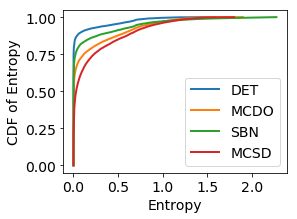

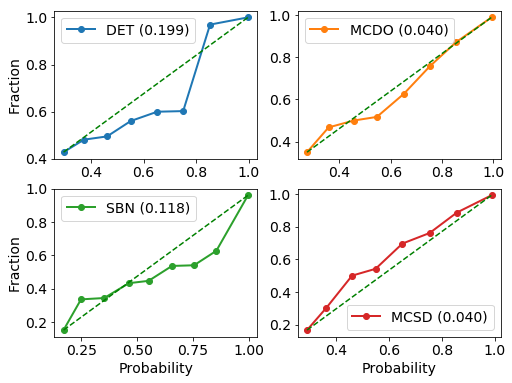

In [14]:
# Init drawings
plt.figure(2, figsize=(4,3))
plt.rcParams['font.size'] = '14'

name_trans = {'deterministic': 'DET',
              'spatial_dropout': 'MCDO',
              'batch_normalization': 'SBN',
              'stochastic_depth': 'MCSD'}

pos = {0: [0, 0], 1: [0, 1], 2: [1, 0], 3: [1, 1]}

fig, axes = plt.subplots(2, 2, figsize=(8,6))

for key, item in results.items():
    # Calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(item['prediction'], 
                                                          torch.max(item['probability'], dim=1)[0], n_bins=10)
    
    # Brier score
    bs = brier_score_loss(item['prediction'], torch.max(item['probability'], dim=1)[0], pos_label=item['prediction'].max())
    ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    # Plots
    axes[pos[key][0], pos[key][1]].plot(np.sort(mean_predicted_value), np.sort(fraction_of_positives), 'o-',linewidth=2.0, 
                                            markersize=6, label=name_trans[item['method']]+' ({0:.3f})'.format(ece), 
                                            color='C{}'.format(key))

    axes[pos[key][0], pos[key][1]].plot(np.linspace(mean_predicted_value.min(), mean_predicted_value.max(),10), 
                                        np.linspace(fraction_of_positives.min(), fraction_of_positives.max(),10),'g--')
    
    #axes[pos[key][0], pos[key][1]].plot(np.linspace(0,1,10),np.linspace(0,1,10),'g--')
    
    axes[1, pos[key][1]].set_xlabel('Probability')
    axes[pos[key][0], 0].set_ylabel('Fraction')
    axes[pos[key][0], pos[key][1]].legend(loc='best')

    
    plt.figure(2)
    plt.plot(*utils.entropy_plot_xy(item['probability'].cpu().numpy()), 
             linewidth=2.0, markersize=6, label=name_trans[item['method']])

#fig.savefig('../graphics/calibration_svhn_resnet20.pdf', bbox_inches='tight', pad_inches=0)

fig = plt.figure(2)
plt.xlabel('Entropy')
plt.ylabel('CDF of Entropy')
plt.legend()
#plt.grid()

plt.show()

#fig.savefig('../graphics/IND_CIFAR_10.pdf', bbox_inches='tight', pad_inches=0)

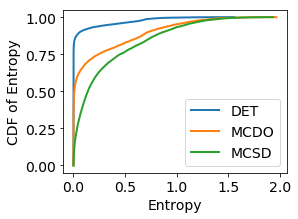

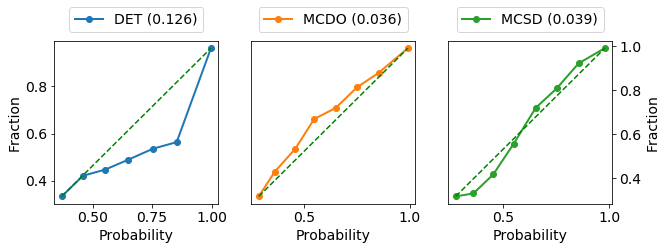

In [65]:
# Init drawings
plt.figure(2, figsize=(4,3))

plt.rcParams['font.size'] = '14'

name_trans = {'deterministic': 'DET',
              'spatial_dropout': 'MCDO',
              'batch_normalization': 'SBN',
              'stochastic_depth': 'MCSD'}

#pos = {0: [0, 0], 1: [0, 1], 2: [1, 0], 3: [1, 1]}

pos = {0: [0, 0], 1: [0, 1], 2: [0, 2]}

fig, axes = plt.subplots(1, 3, figsize=(10,3))

for key, item in results.items():
    # Calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(item['prediction'], 
                                                          torch.max(item['probability'], dim=1)[0], n_bins=10)
    
    # Brier score
    bs = brier_score_loss(item['prediction'], torch.max(item['probability'], dim=1)[0], pos_label=item['prediction'].max())
    ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    # Plots
    axes[key].plot(np.sort(mean_predicted_value), np.sort(fraction_of_positives), 'o-',linewidth=2.0, 
                                            markersize=6, label=name_trans[item['method']]+' ({0:.3f})'.format(ece), 
                                            color='C{}'.format(key))

    axes[key].plot(np.linspace(mean_predicted_value.min(), mean_predicted_value.max(),10), 
                                        np.linspace(fraction_of_positives.min(), fraction_of_positives.max(),10),'g--')
    
    #axes[pos[key][0], pos[key][1]].plot(np.linspace(0,1,10),np.linspace(0,1,10),'g--')
    
    axes[key].set_xlabel('Probability')
    axes[key].set_ylabel('Fraction')
    axes[key].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25))
    axes[1].get_yaxis().set_visible(False)
    #axes[1].get_yaxis().set_visible(False)
    axes[2].yaxis.tick_right()
    axes[2].yaxis.set_label_position("right")

    
    plt.figure(2)
    plt.plot(*utils.entropy_plot_xy(item['probability'].cpu().numpy()), 
             linewidth=2.0, markersize=6, label=name_trans[item['method']])

#fig.savefig('../graphics/calibration_cifar10_resnet20_no_shift_scale.pdf', bbox_inches='tight', pad_inches=0)

fig = plt.figure(2)
plt.xlabel('Entropy')
plt.ylabel('CDF of Entropy')
plt.legend()
#plt.grid()

plt.show()

#fig.savefig('../graphics/IND_CIFAR_10.pdf', bbox_inches='tight', pad_inches=0)

### 1.4 Predictive uncertainty

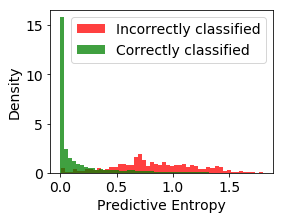

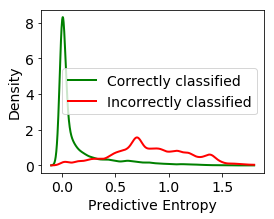

In [22]:
plt.rcParams["font.size"] = "14"

# Histograms
fig = plt.figure(figsize=(4,3)) #figsize=(20,10))
plt.hist(uncertainty[prediction == 0], 50, density=True, facecolor='r', alpha=0.75, label='Incorrectly classified')
plt.hist(uncertainty[prediction == 1], 50, density=True, facecolor='g', alpha=0.75, label='Correctly classified')
plt.xlabel('Predictive Entropy')
plt.ylabel('Density')
plt.legend(loc='best')

fig.savefig("predictive_entropy_cifar10_MCSD.pdf", bbox_inches='tight', pad_inches=0)

# Kernel density estimator
fig = plt.figure(figsize=(4,3))
density = gaussian_kde(uncertainty[prediction == 1])
xs = np.linspace(-0.1, uncertainty.max(), 1000)
density.covariance_factor = lambda : .1
density._compute_covariance()
plt.plot(xs, density(xs), 'g', linewidth=2.0, markersize=6, label='Correctly classified')

density = gaussian_kde(uncertainty[prediction == 0])
xs = np.linspace(-0.1, uncertainty.max(), 1000)
density.covariance_factor = lambda : .1
density._compute_covariance()
plt.plot(xs, density(xs), 'r', linewidth=2.0, markersize=6, label='Incorrectly classified')

plt.xlabel('Predictive Entropy')
plt.ylabel('Density')
plt.legend(loc='best')
plt.show()

